# Titanic

Purpose of the notebook is to 
* explore data
* profile features
* generate new features
* fit a classifier to predict if a given passenger survives or not


## Import Libraries

In [13]:
%matplotlib inline

import os 
import sys

import pandas as pd
import sklearn

## Define Constants

In [14]:
NOTEBOOK_DIR = os.path.dirname(os.path.abspath('load_data.ipynb'))
PROJECT_ROOT = os.path.join(NOTEBOOK_DIR, '..')
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')

TRAIN_CSV = 'train.csv'
TRAIN_CSV_PATH = os.path.join(DATA_DIR, TRAIN_CSV)

## Import Data

In [15]:
data = pd.read_csv(TRAIN_CSV_PATH)

## Profile Data

In [16]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [17]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


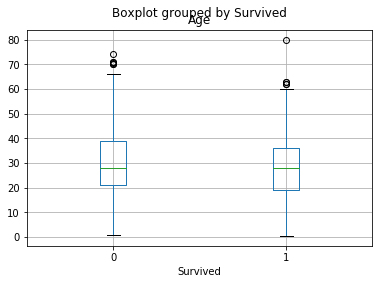

In [18]:
data.boxplot(column='Age', by='Survived')

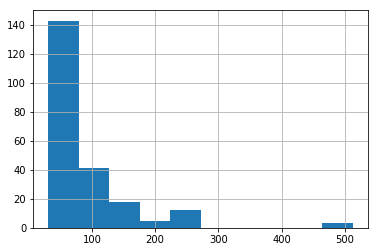

In [19]:
most_expensive = data.Fare > 31
data[most_expensive].Fare.hist()

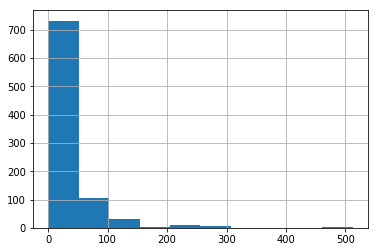

In [20]:
data.Fare.hist()

### Interesting Points

* 62% of passengers died in the training set
* Several ages are missing, this will be an important feature as I can imagine there is a high rate of mortality amongst the younger and elderly
* Nothing is particularly strange about `SibSp` or `Parch` although I am not entirely sure how much these features will be predictive.
* Looking at `Fare` it looks like there may possibly be some outliers/typos since the max value is ~17x the size of the third quartile, seems strange

Further Notes:

Researching the price of a ticket, apparently some of the tickets were incredibly expensive, and it's quite possible the value of a single ticket was 500. Apparently the prices were something like:

* First Class (parlor suite) — £870/$4,350 ($50,000 today).
* First Class (berth)— £30/$150 ($1724 today).
* Second Class — £12/$60 ($690 today).
* Third Class — £3 to £8/$40 ($172 to $460 today).

From: https://www.quora.com/What-were-the-ticket-prices-to-board-the-Titanic


In [21]:
data.loc[:,['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']].describe().T

,count,unique,top,freq
Name,891,891,"Hansen, Mr. Henry Damsgaard",1
Sex,891,2,male,577
Ticket,891,681,347082,7
Cabin,204,147,B96 B98,4
Embarked,889,3,S,644


### Intersting Points:

#### `Name`
* all unique but seems to often have multiple names inside

#### `Ticket`
* There is a value in every row but some of them up duplicated.
* Mix of numeric, alphabetic, and slashes. Could try splitting these into the alphabetic and numeric part at least

#### `Cabin`
* Many missing values
* Duplicates too
* Some rows appear to contain multiple cabin values
* Could also be split into alphabetic and numeric parts, not sure how to handle multiple/different cabin values

## Cleanup Data

* impute missing `Age`
* do alphabetic, numeric split on `Ticket` and `Cabin`
* parse out titles in `Name`


In [22]:
 from collections import Counter


In [23]:
data['cabin_letter'] = data.Cabin.apply(lambda cabin: '-' if pd.isna(cabin) else Counter([char for char in cabin if char.isalpha()]).most_common(1)[0][0])

In [32]:
data[]

[('i', 3)]

In [27]:
data.fillna?

In [29]:
data.Ticket.unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'S.O.C. 14879', '2680', '1601', '348123', '349208', '374746',
       '248738', '364516', '345767', '345779', '330932', '113059',
       'SO/C 14885', '31012